In [2]:
import os,time
import glob
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
inputDir = '../data/train'
testDir = '../data/validation'
outputDir = 'output'
from random import shuffle



In [3]:
def myshow(img, title=None, margin=0.05, dpi=100):
    nda = sitk.GetArrayViewFromImage(img)
    spacing = img.GetSpacing()
        
    if nda.ndim == 3:
        # fastest dim, either component or x
        c = nda.shape[-1]
        
        # the the number of components is 3 or 4 consider it an RGB image
        if not c in (3,4):
            nda = nda[nda.shape[0]//2,:,:]
    
    elif nda.ndim == 4:
        c = nda.shape[-1]
        
        if not c in (3,4):
            raise Runtime("Unable to show 3D-vector Image")
            
        # take a z-slice
        nda = nda[nda.shape[0]//2,:,:,:]
            
    ysize = nda.shape[0]
    xsize = nda.shape[1]
      
    # Make a figure big enough to accommodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    figsize = (4 + margin) * ysize / dpi, (4 + margin) * xsize / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    # Make the axis the right size...
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
   
    extent = (0, xsize*spacing[1], ysize*spacing[0], 0)
    
    t = ax.imshow(nda,extent=extent,interpolation=None)
    
    if nda.ndim == 2:
        t.set_cmap("gray")
    
    if(title):
        plt.title(title)

In [4]:
def loadData( inputDir, padding=0 ):
    imageflairFilenames = glob.glob(os.path.join(inputDir, "Utrecht", "*","pre","FLAIR.nii.gz"))
    imageT1Filenames = glob.glob(os.path.join(inputDir, "Utrecht", "*","pre","T1.nii.gz"))
    labelFilenames= glob.glob(os.path.join(inputDir, "Utrecht", "*","wmh.nii.gz"))
    images = None # shape: (numImages, z, y, x, channels=1)
    labels = None
    masks  = None
    print(len(imageflairFilenames))
    for imageflairFilenames, imageT1Filenames, labelFilenames in zip(imageflairFilenames, imageT1Filenames, labelFilenames):
        # Load the images
        flairImage = sitk.ReadImage(imageflairFilenames)
        T1Image = sitk.ReadImage(imageT1Filenames)
        labelImage = sitk.ReadImage(labelFilenames)
        # Convert to arrays
        flairArray = np.pad(sitk.GetArrayFromImage(flairImage), [(0,0),(padding,padding),(padding,padding)], 'constant')
        T1Array = np.pad(sitk.GetArrayFromImage(T1Image), [(0,0),(padding,padding),(padding,padding)], 'constant')
        labelArray = np.pad(sitk.GetArrayFromImage(labelImage), [(0,0),(padding,padding),(padding,padding)], 'constant')
        maskArray = labelArray > 0
        print("flairArray",flairArray.shape)
        print("T1Array",T1Array.shape)
        print("labelArray",labelArray.shape)
        print("maskArray",maskArray.shape)
        # Add to the images/labels array
        if images is None:
            images = flairArray.reshape([1] + list(flairArray.shape) + [1])
            images = np.concatenate([images, T1Array.reshape([1] + list(T1Array.shape) + [1])], axis=4)
            labels = labelArray.reshape([1] + list(labelArray.shape) + [1])
            masks  = maskArray.reshape([1] + list(maskArray.shape) + [1])
        else:
            tempArray = np.concatenate([flairArray.reshape([1] + list(flairArray.shape) + [1]), T1Array.reshape([1] + list(T1Array.shape) + [1])], axis=4)
            
            images = np.concatenate([images, tempArray])
            
            labels = np.concatenate([labels, labelArray.reshape([1] + list(labelArray.shape) + [1])])
            masks  = np.concatenate([masks, maskArray.reshape([1] + list(maskArray.shape) + [1])])
                    
    return images, labels, masks

In [5]:
testImages, testLabels, testMasks = loadData(testDir)
testNonZeroIdx = np.nonzero(testMasks)
trainImages, trainLabels, trainMasks = loadData(inputDir)
trainNonZeroIdx = np.nonzero(testMasks)

5
flairArray (48, 240, 240)
T1Array (48, 240, 240)
labelArray (48, 240, 240)
maskArray (48, 240, 240)
flairArray (48, 240, 240)
T1Array (48, 240, 240)
labelArray (48, 240, 240)
maskArray (48, 240, 240)
flairArray (48, 240, 240)
T1Array (48, 240, 240)
labelArray (48, 240, 240)
maskArray (48, 240, 240)
flairArray (48, 240, 240)
T1Array (48, 240, 240)
labelArray (48, 240, 240)
maskArray (48, 240, 240)
flairArray (48, 240, 240)
T1Array (48, 240, 240)
labelArray (48, 240, 240)
maskArray (48, 240, 240)
15
flairArray (48, 240, 240)
T1Array (48, 240, 240)
labelArray (48, 240, 240)
maskArray (48, 240, 240)
flairArray (48, 240, 240)
T1Array (48, 240, 240)
labelArray (48, 240, 240)
maskArray (48, 240, 240)
flairArray (48, 240, 240)
T1Array (48, 240, 240)
labelArray (48, 240, 240)
maskArray (48, 240, 240)
flairArray (48, 240, 240)
T1Array (48, 240, 240)
labelArray (48, 240, 240)
maskArray (48, 240, 240)
flairArray (48, 240, 240)
T1Array (48, 240, 240)
labelArray (48, 240, 240)
maskArray (48, 240, 

In [6]:
testMasks.shape[0]

5

In [7]:
trainMasks.shape

(15, 48, 240, 240, 1)

In [8]:
trainimages = []
trainlables = []
for i in range(trainMasks.shape[0]):
    for j in range(trainMasks.shape[1]):
        if not np.all(trainMasks[i,j,:,:,0]== False):
            trainlables.append(trainLabels[i,j,:,:,:])
            trainimages.append(trainImages[i,j,:,:,:])

testimages = []
testlables = []
for i in range(testMasks.shape[0]):
    for j in range(testMasks.shape[1]):
        if not np.all(testMasks[i,j,:,:,0]== False):
            testlables.append(testLabels[i,j,:,:,:])
            testimages.append(testImages[i,j,:,:,:])

In [9]:
X = np.asarray(trainimages)
y = np.asarray(trainlables).astype(int)
y[y >1] = 0
print(X.shape, X.min(), X.max()) # (240, 240, 4) -0.380588 2.62761
print(y.shape, y.min(), y.max()) # (240, 240, 1) 0 1 

Xtest = np.asarray(testimages)
ytest = np.asarray(testlables).astype(int)
ytest[ytest >1] = 0
print(Xtest.shape, Xtest.min(), Xtest.max()) # (240, 240, 4) -0.380588 2.62761
print(ytest.shape, ytest.min(), ytest.max()) # (240, 240, 1) 0 1 

(402, 240, 240, 2) 0.0 3168.0
(402, 240, 240, 1) 0 1
(138, 240, 240, 2) 0.0 2641.0
(138, 240, 240, 1) 0 1


In [10]:


def shuffle_list(*ls):
    l =list(zip(*ls))
    shuffle(l)
    return zip(*l)

Xs,ys = shuffle_list(X,y)
Xs= np.array(Xs)
ys= np.array(ys)
print(Xs.shape)
print(ys.shape)


(402, 240, 240, 2)
(402, 240, 240, 1)


## U net

In [11]:
from __future__ import print_function

import os
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout,UpSampling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

C:\Users\Jing\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [12]:
def get_unet():
    inputs = Input(batchShape[1:])
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = -1)
    conv6 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = -1)
    conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = -1)
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = -1)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)


    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

    model.summary()
    return model

In [13]:
def preprocess(imgs):
#   print("pree",imgs.shape, imgs.shape[:-1])
    imgs_p = np.ndarray((imgs.shape[0],img_rows, img_cols,imgs.shape[-1]), dtype=np.uint8)
#     print("imgs.shape[0]",imgs.shape[0])
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(imgs[i],(img_cols, img_rows,imgs.shape[-1]), preserve_range=True)
  
#   print("imgs_p",imgs_p.shape)
    return imgs_p

In [19]:
def train_and_predict(X,y):
    print('-'*30)
    print('Loading and preprocessing train data...')
    print('-'*30)
    imgs_train, imgs_mask_train = np.array(X), np.array(y)#load_train_data()
#     myshow(sitk.GetImageFromArray(imgs_train[:,:,0]))
#     myshow(sitk.GetImageFromArray(imgs_train[:,:,1]))
#     myshow(sitk.GetImageFromArray(imgs_mask_train))
#     print("shape before",imgs_train.shape,imgs_mask_train.shape)
#     myshow(sitk.GetImageFromArray(imgs_train))

    imgs_train = preprocess(imgs_train)
    imgs_mask_train = preprocess(imgs_mask_train)
#     print("shapeagfter",imgs_train.shape,imgs_mask_train.shape)
#     myshow(sitk.GetImageFromArray(imgs_train))

    imgs_train = imgs_train.astype('float32')
    mean = np.mean(imgs_train)  # mean for data centering
    std = np.std(imgs_train)  # std for data normalization

    imgs_train -= mean
    imgs_train /= std

    imgs_mask_train = imgs_mask_train.astype('float32')
    imgs_mask_train /= 255.  # scale masks to [0, 1]

    print('-'*30)
    print('Creating and compiling model...')
    print('-'*30)
    model = get_unet()
    model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

    print('-'*30)
    print('Fitting model...')
    print('-'*30)
# #     myshow(sitk.GetImageFromArray(imgs_train))
#     myshow(sitk.GetImageFromArray(imgs_mask_train))
#     print("before model",imgs_train.shape,imgs_mask_train.shape)
    model.fit(imgs_train, imgs_mask_train, batch_size=20, nb_epoch=1, verbose=1, shuffle=True,
              validation_split=0.2,
              callbacks=[model_checkpoint])
    
    
    print('-'*30)
    print('Loading and preprocessing test data...')
    print('-'*30)
    testrange = range(len(ytest))
    imgs_test, imgs_id_test = Xtest, ytest
#     print("before test pre",imgs_test.shape,imgs_id_test)
    imgs_test = preprocess(imgs_test)
#     print("after test pre",imgs_test.shape,imgs_id_test)
    imgs_test = imgs_test.astype('float32')
    imgs_test -= mean
    imgs_test /= std

    print('-'*30)
    print('Loading saved weights...')
    print('-'*30)
    model.load_weights('weights.h5')

    print('-'*30)
    print('Predicting masks on test data...')
    print('-'*30)
#     print("test model",imgs_test.shape)
    imgs_mask_test = model.predict(imgs_test, verbose=1)
    print("test model finished",imgs_mask_test.shape)
    np.save('imgs_mask_test.npy', imgs_mask_test)
    myshow(sitk.GetImageFromArray(imgs_test[30,:,:,1]))
    myshow(sitk.GetImageFromArray(imgs_id_test[30,:,:,0]))
    myshow(sitk.GetImageFromArray(imgs_mask_test[30,:,:,0]))
    print('-' * 30)
    print('Saving predicted masks to files...')
    print('-' * 30)
    pred_dir = 'preds'
    if not os.path.exists(pred_dir):
        os.mkdir(pred_dir)
    for image, image_id in zip(imgs_mask_test, testrange):
#         print(image_id)
        nn = 0
#         print(image.shape)
        image = (image[:, :, 0] * 255.).astype(np.uint8)
        imsave(os.path.join(pred_dir,str(image_id) + '_pred.png'), image)
        nn+=1

In [15]:
img_rows =256
img_cols =256

smooth = 1.

batchSize = 20
batchShape = (batchSize, 256,256, 2)

In [16]:

Xchunks = [Xs[x:x+100] for x in range(0, len(Xs), 100)]
ychunks = [ys[x:x+100] for x in range(0, len(ys), 100)]


------------------------------
Loading and preprocessing train data...
------------------------------


C:\Users\Jing\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Jing\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


------------------------------
Creating and compiling model...
------------------------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 2)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 608         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 32) 0           conv2d_2[0][0]                   
_______________

C:\Users\Jing\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 80 samples, validate on 20 samples
Epoch 1/3
80/80 [==============================] - 73s 912ms/step - loss: 0.6816 - acc: 0.7872 - val_loss: 0.6565 - val_acc: 0.9883
Epoch 2/3
80/80 [==============================] - 72s 901ms/step - loss: 0.5543 - acc: 0.9817 - val_loss: 0.5021 - val_acc: 0.9913
Epoch 3/3
80/80 [==============================] - 71s 884ms/step - loss: 0.3190 - acc: 0.9930 - val_loss: 0.2809 - val_acc: 0.9913
------------------------------
Loading and preprocessing test data...
------------------------------
------------------------------
Loading saved weights...
------------------------------
------------------------------
Predicting masks on test data...
------------------------------
138/138 [==============================] - 36s 260ms/step
test model finished (138, 256, 256, 1)
------------------------------
Saving predicted masks to files...
------------------------------
------------------------------
Loading and preprocessing train data...
------------

Train on 80 samples, validate on 20 samples
Epoch 1/3
80/80 [==============================] - 74s 925ms/step - loss: 0.0446 - acc: 0.9973 - val_loss: 0.0147 - val_acc: 0.9951
Epoch 2/3
80/80 [==============================] - 72s 899ms/step - loss: 0.0044 - acc: 0.9973 - val_loss: 0.0041 - val_acc: 0.9951
Epoch 3/3
80/80 [==============================] - 71s 890ms/step - loss: 0.0016 - acc: 0.9973 - val_loss: 0.0018 - val_acc: 0.9951
------------------------------
Loading and preprocessing test data...
------------------------------
------------------------------
Loading saved weights...
------------------------------
------------------------------
Predicting masks on test data...
------------------------------
138/138 [==============================] - 36s 259ms/step
test model finished (138, 256, 256, 1)
------------------------------
Saving predicted masks to files...
------------------------------


C:\Users\Jing\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: preds\0_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Users\Jing\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: preds\1_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Users\Jing\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: preds\2_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Users\Jing\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: preds\3_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Users\Jing\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: preds\4_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Users\Jing\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: preds\5_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Users\Jing\An

C:\Users\Jing\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: preds\69_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Users\Jing\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: preds\70_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Users\Jing\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: preds\71_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Users\Jing\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: preds\72_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Users\Jing\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: preds\73_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Users\Jing\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: preds\74_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Users\J

------------------------------
Loading and preprocessing train data...
------------------------------
------------------------------
Creating and compiling model...
------------------------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 2)  0                                            
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 256, 256, 32) 608         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, 256, 256, 32) 9248        conv2d_49[0][0]                  
__________________________________________________________________________________________________
max_pooling2

Train on 80 samples, validate on 20 samples
Epoch 1/3
80/80 [==============================] - 74s 928ms/step - loss: 1.9674 - acc: 0.2042 - val_loss: 0.7353 - val_acc: 0.7621
Epoch 2/3
80/80 [==============================] - 72s 899ms/step - loss: 0.7333 - acc: 0.8547 - val_loss: 0.6988 - val_acc: 0.9800
Epoch 3/3
80/80 [==============================] - 72s 895ms/step - loss: 0.6986 - acc: 0.9851 - val_loss: 0.6964 - val_acc: 0.9905
------------------------------
Loading and preprocessing test data...
------------------------------
------------------------------
Loading saved weights...
------------------------------
------------------------------
Predicting masks on test data...
------------------------------
138/138 [==============================] - 36s 260ms/step
test model finished (138, 256, 256, 1)
------------------------------
Saving predicted masks to files...
------------------------------
------------------------------
Loading and preprocessing train data...
------------

Train on 80 samples, validate on 20 samples
Epoch 1/3
80/80 [==============================] - 75s 935ms/step - loss: 0.6941 - acc: 0.9628 - val_loss: 0.6931 - val_acc: 0.9888
Epoch 2/3
80/80 [==============================] - 71s 884ms/step - loss: 0.6928 - acc: 0.9919 - val_loss: 0.6926 - val_acc: 0.9964
Epoch 3/3
80/80 [==============================] - 72s 894ms/step - loss: 0.6925 - acc: 0.9947 - val_loss: 0.6925 - val_acc: 0.9977
------------------------------
Loading and preprocessing test data...
------------------------------
------------------------------
Loading saved weights...
------------------------------
------------------------------
Predicting masks on test data...
------------------------------
138/138 [==============================] - 36s 258ms/step
test model finished (138, 256, 256, 1)
------------------------------
Saving predicted masks to files...
------------------------------
------------------------------
Loading and preprocessing train data...
------------

Train on 1 samples, validate on 1 samples
Epoch 1/3
1/1 [==============================] - 3s 3s/step - loss: 0.7425 - acc: 0.3661 - val_loss: 0.7054 - val_acc: 0.7366
Epoch 2/3
1/1 [==============================] - 1s 1s/step - loss: 0.7105 - acc: 0.6191 - val_loss: 0.6960 - val_acc: 0.9232
Epoch 3/3
1/1 [==============================] - 1s 1s/step - loss: 0.6972 - acc: 0.8599 - val_loss: 0.6941 - val_acc: 0.9645
------------------------------
Loading and preprocessing test data...
------------------------------
------------------------------
Loading saved weights...
------------------------------
------------------------------
Predicting masks on test data...
------------------------------
138/138 [==============================] - 36s 260ms/step
test model finished (138, 256, 256, 1)
------------------------------
Saving predicted masks to files...
------------------------------


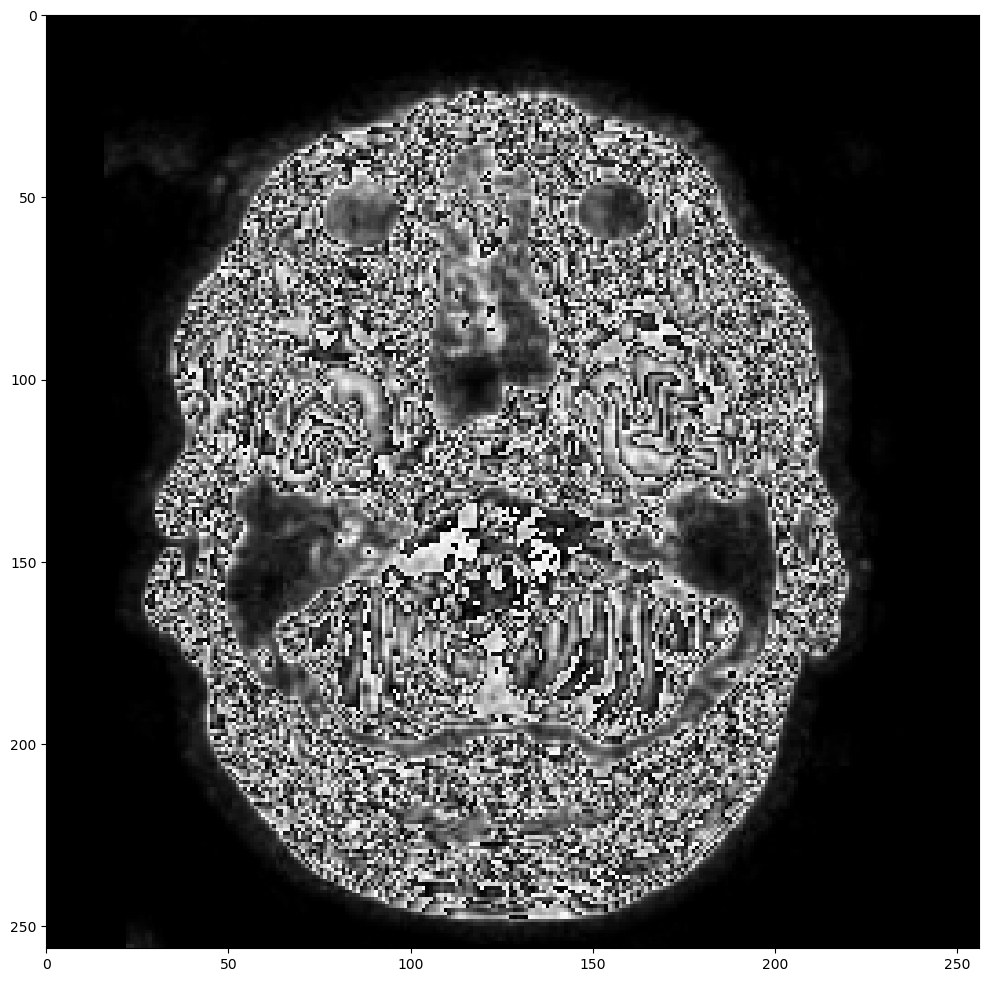

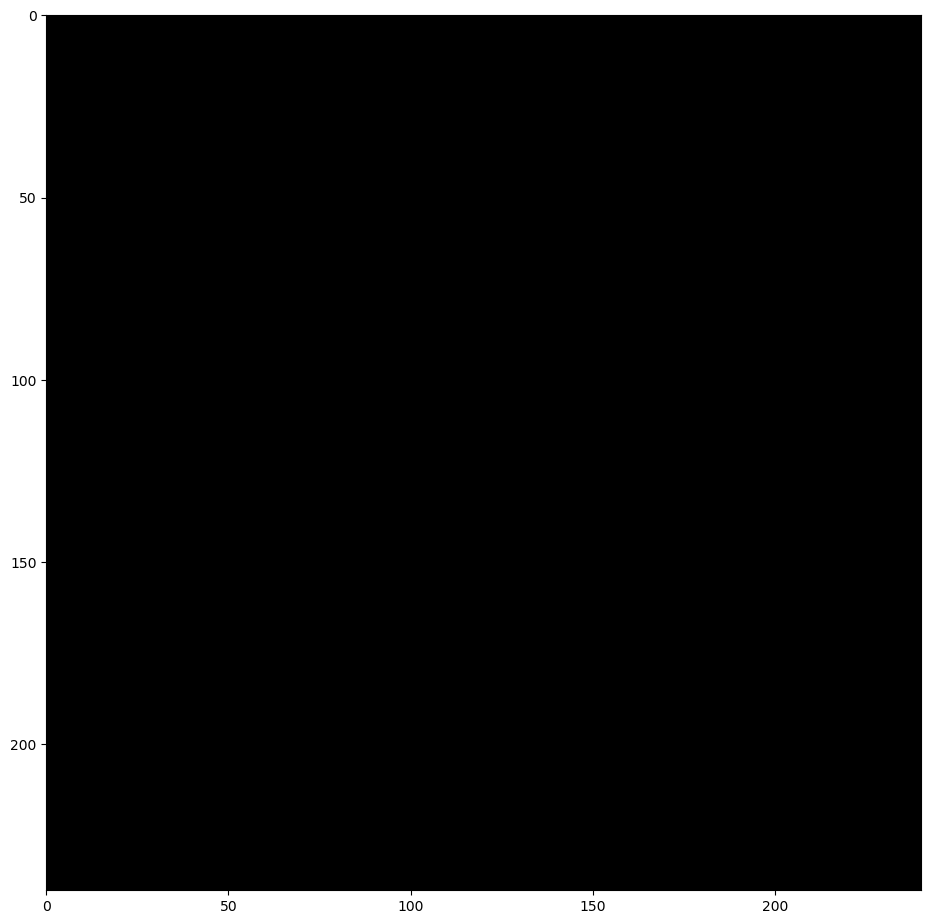

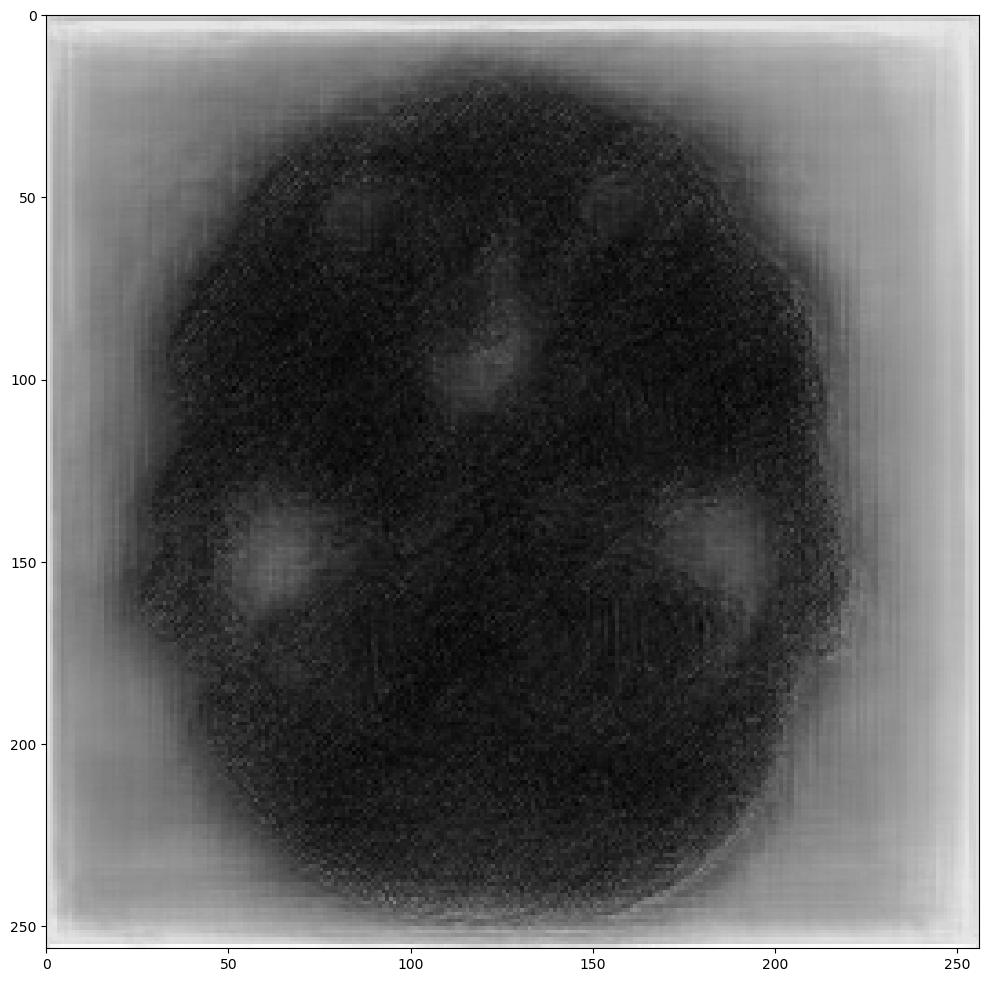

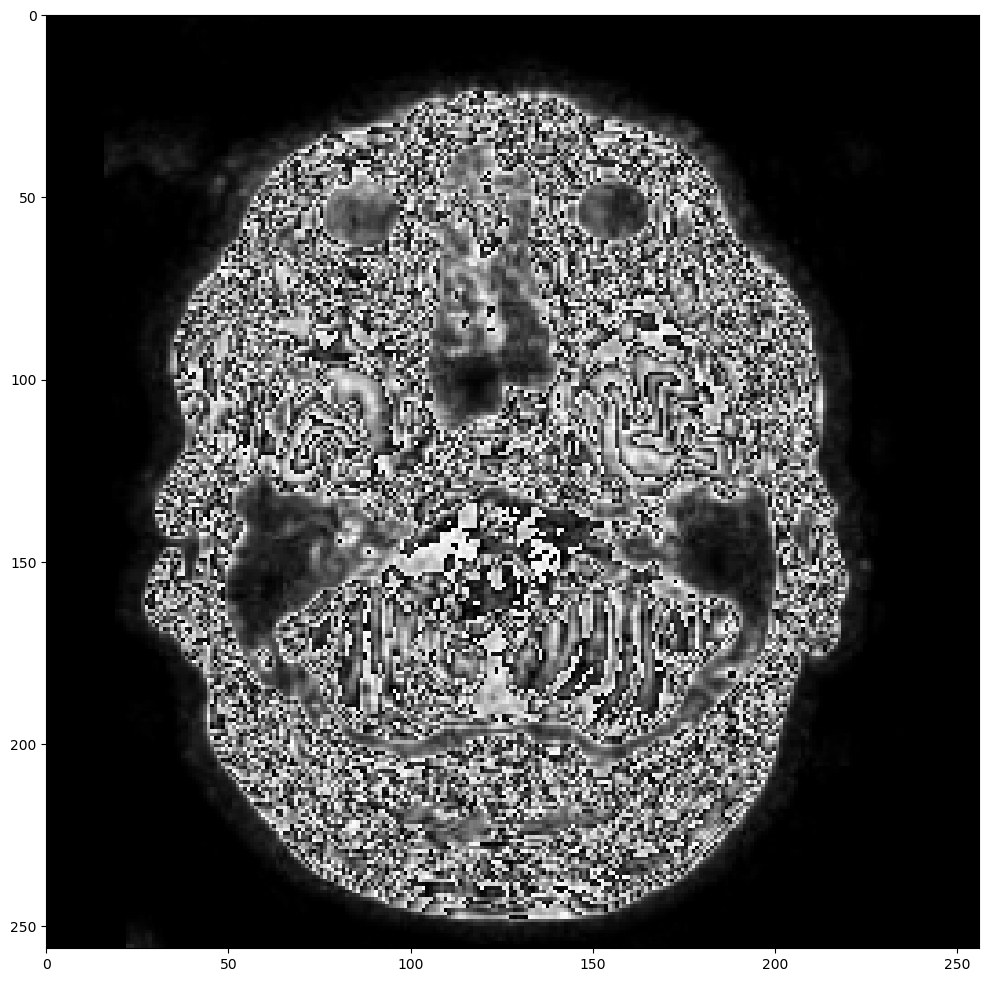

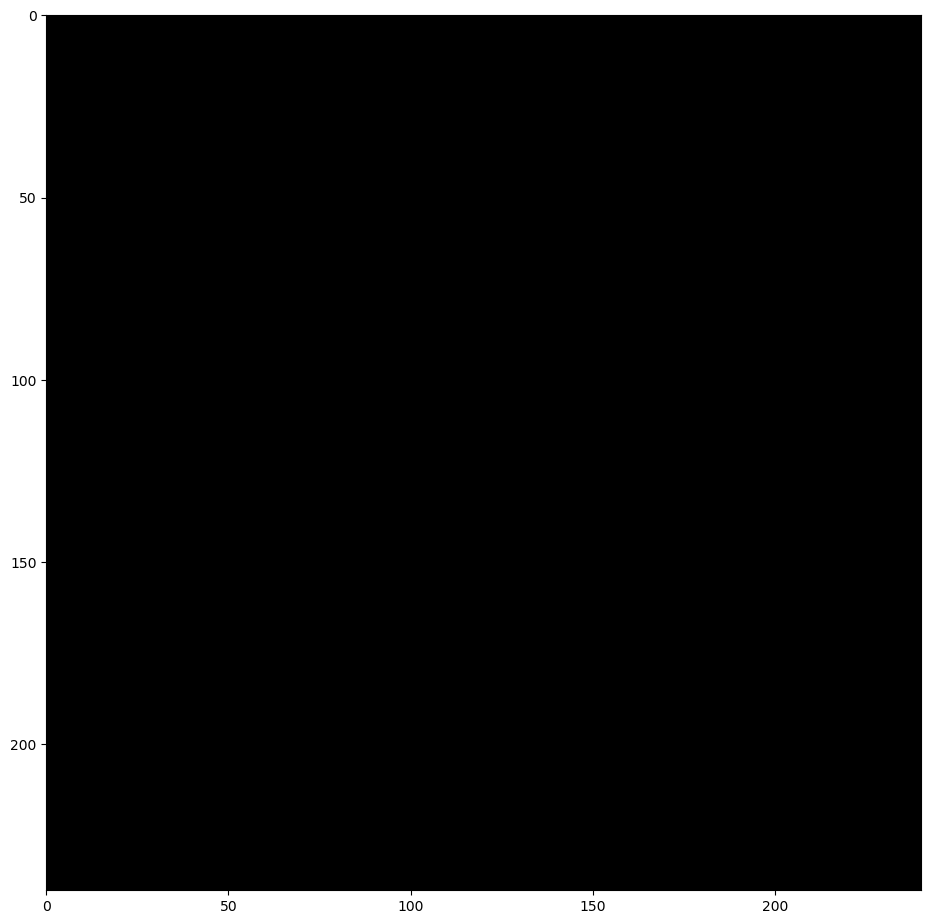

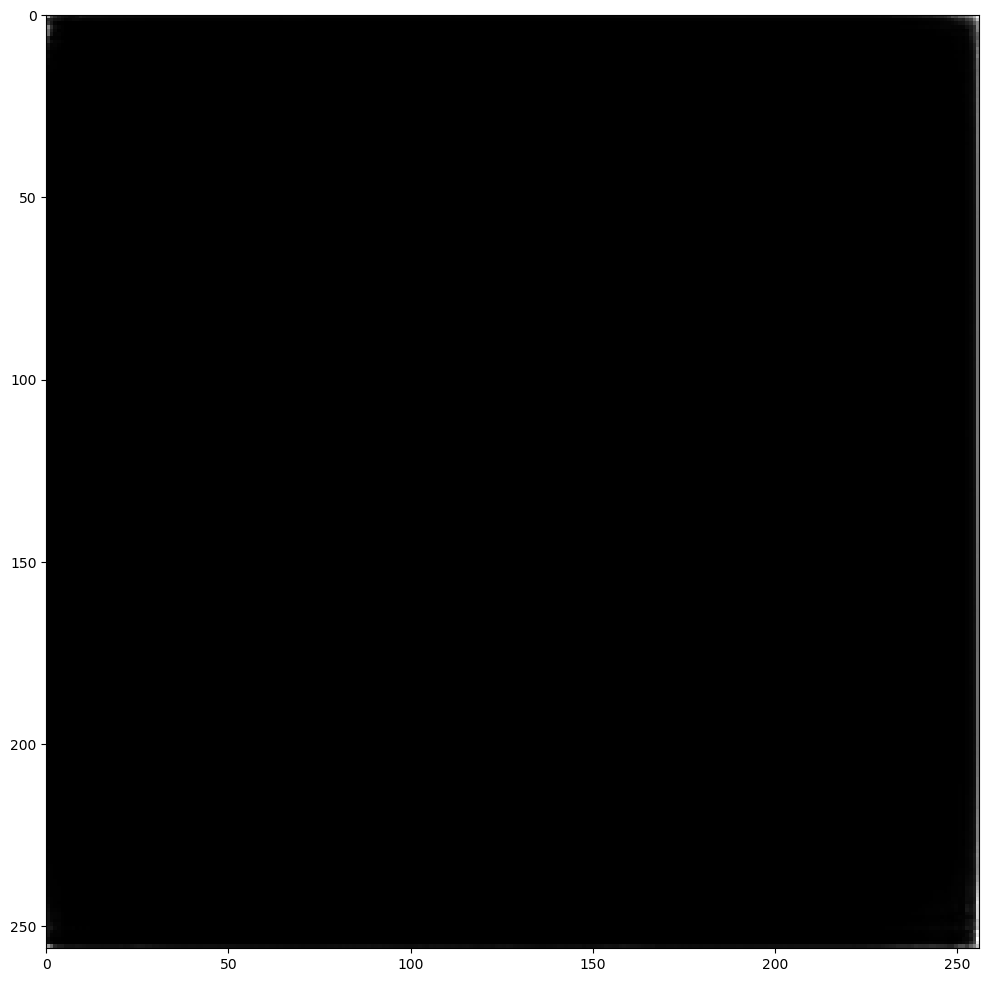

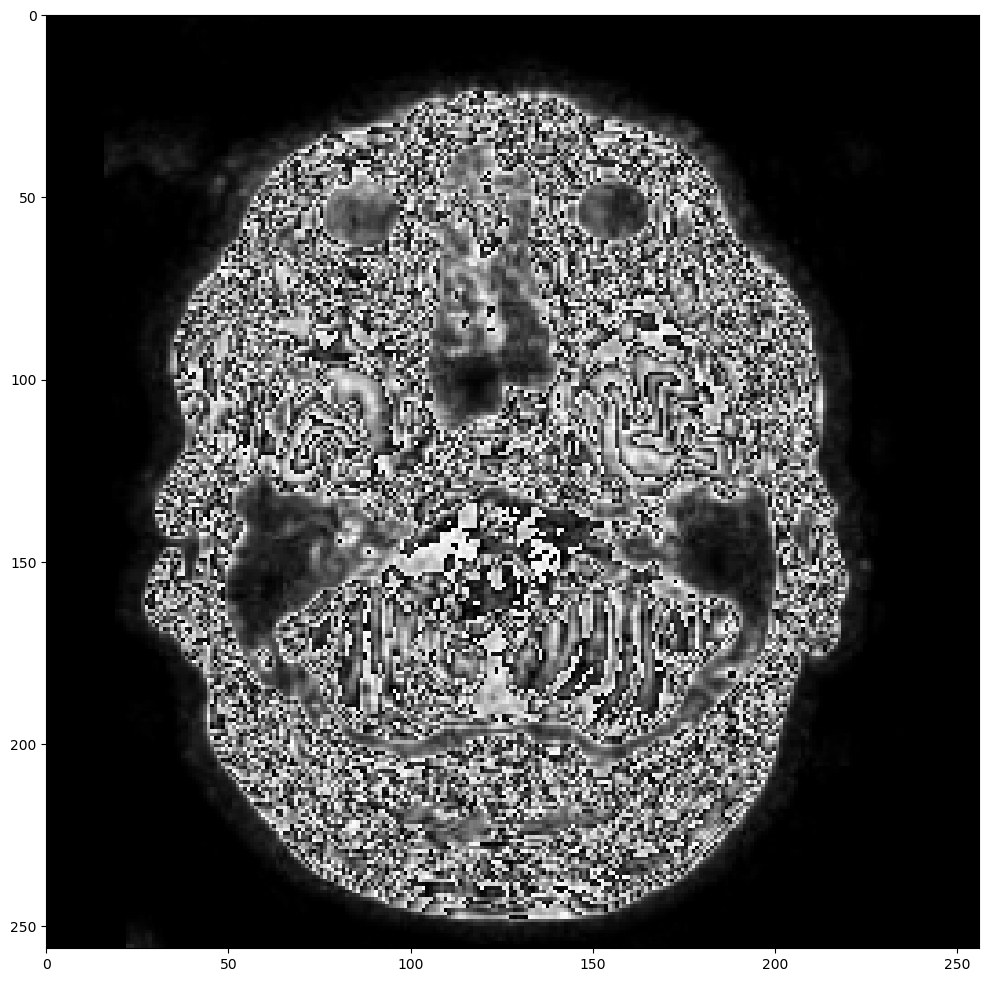

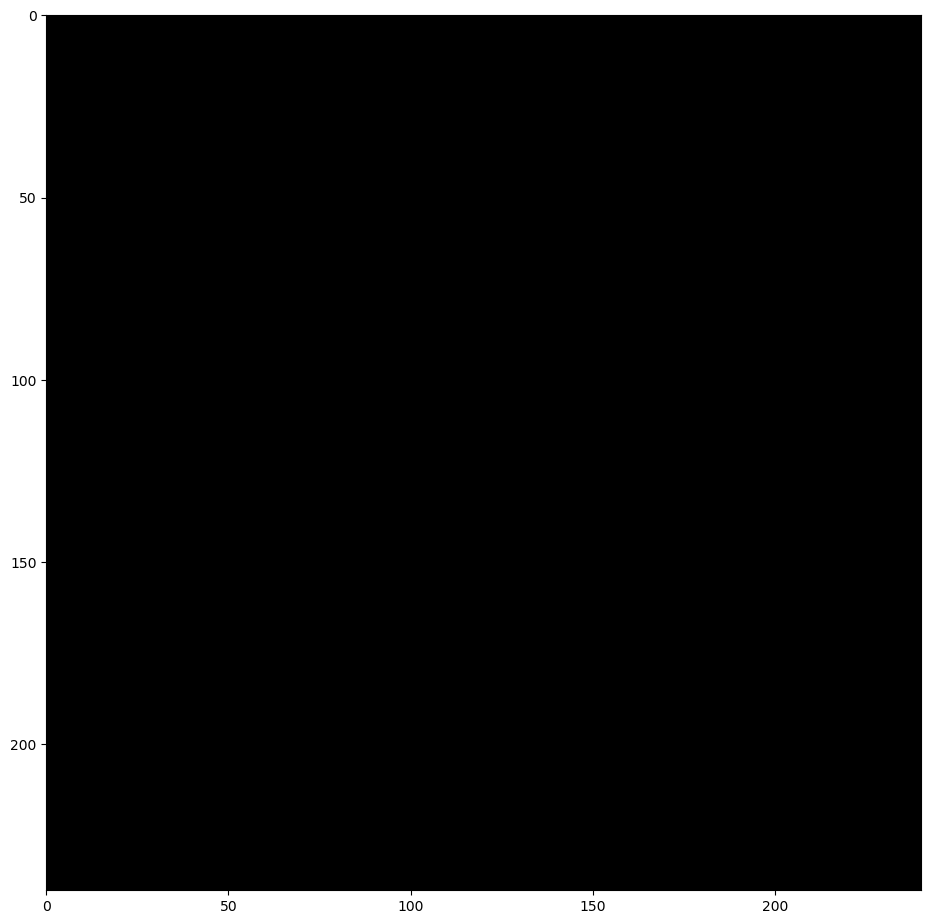

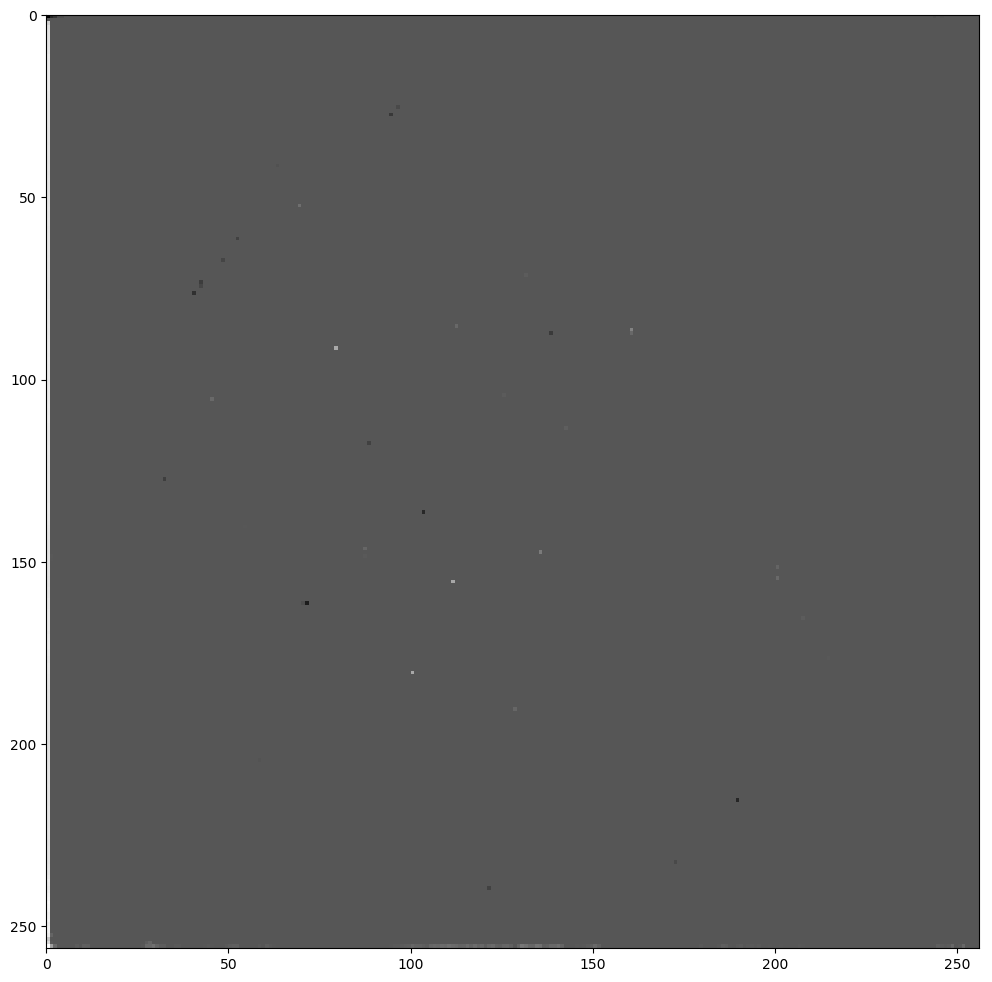

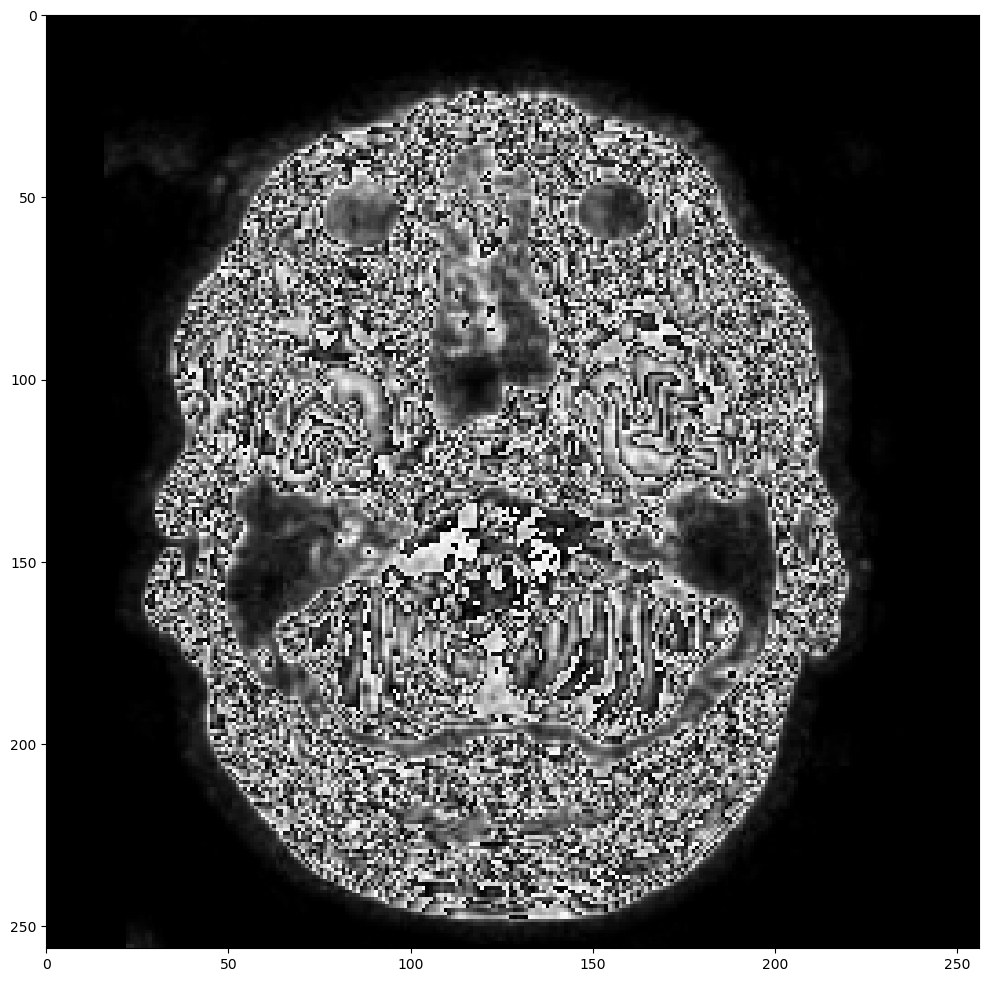

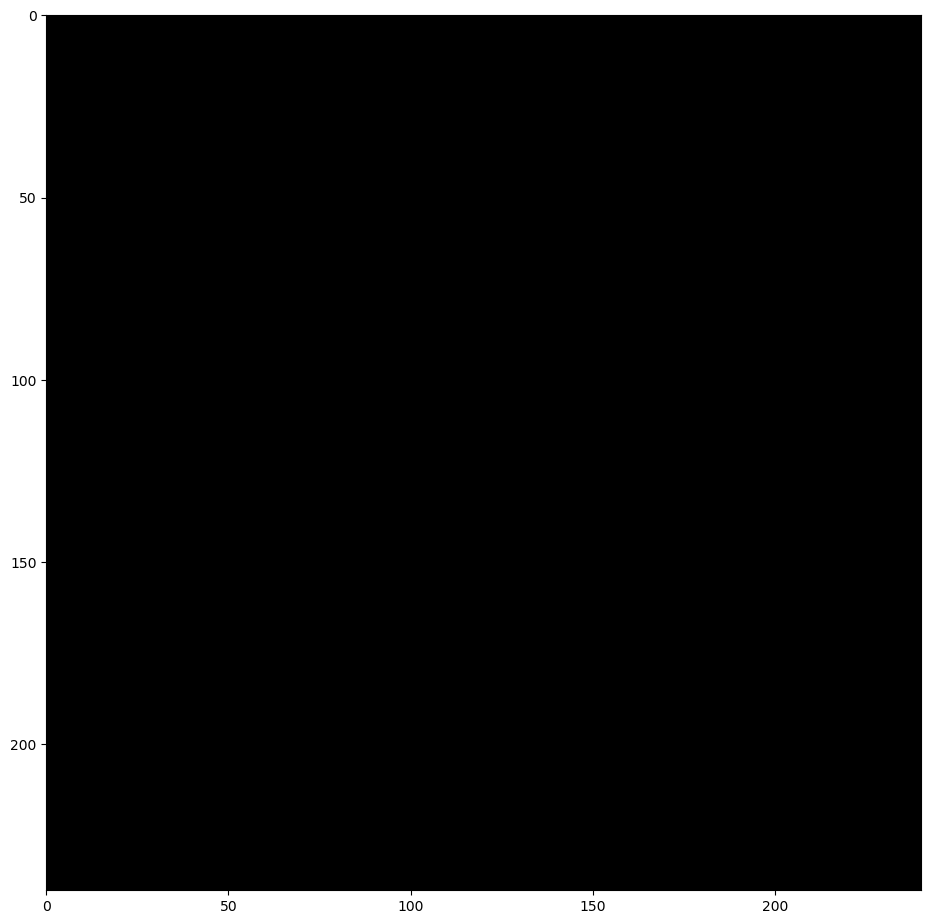

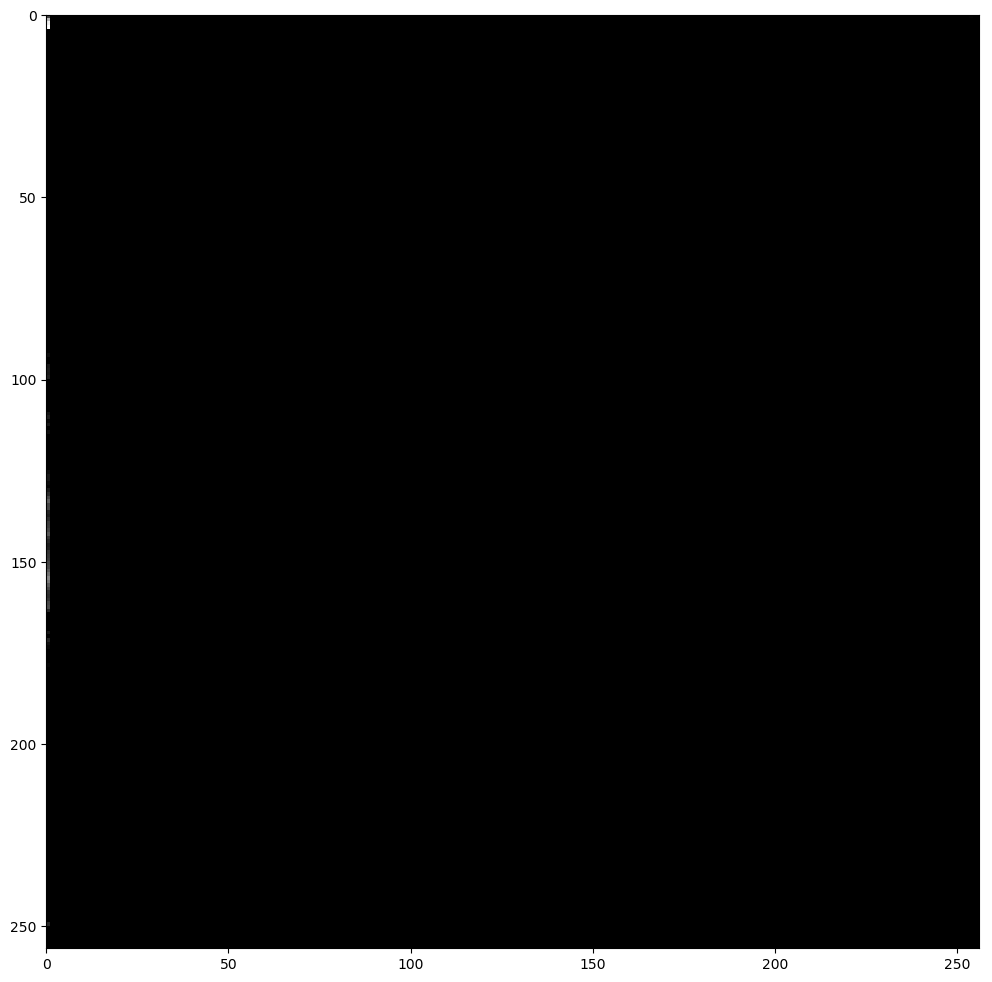

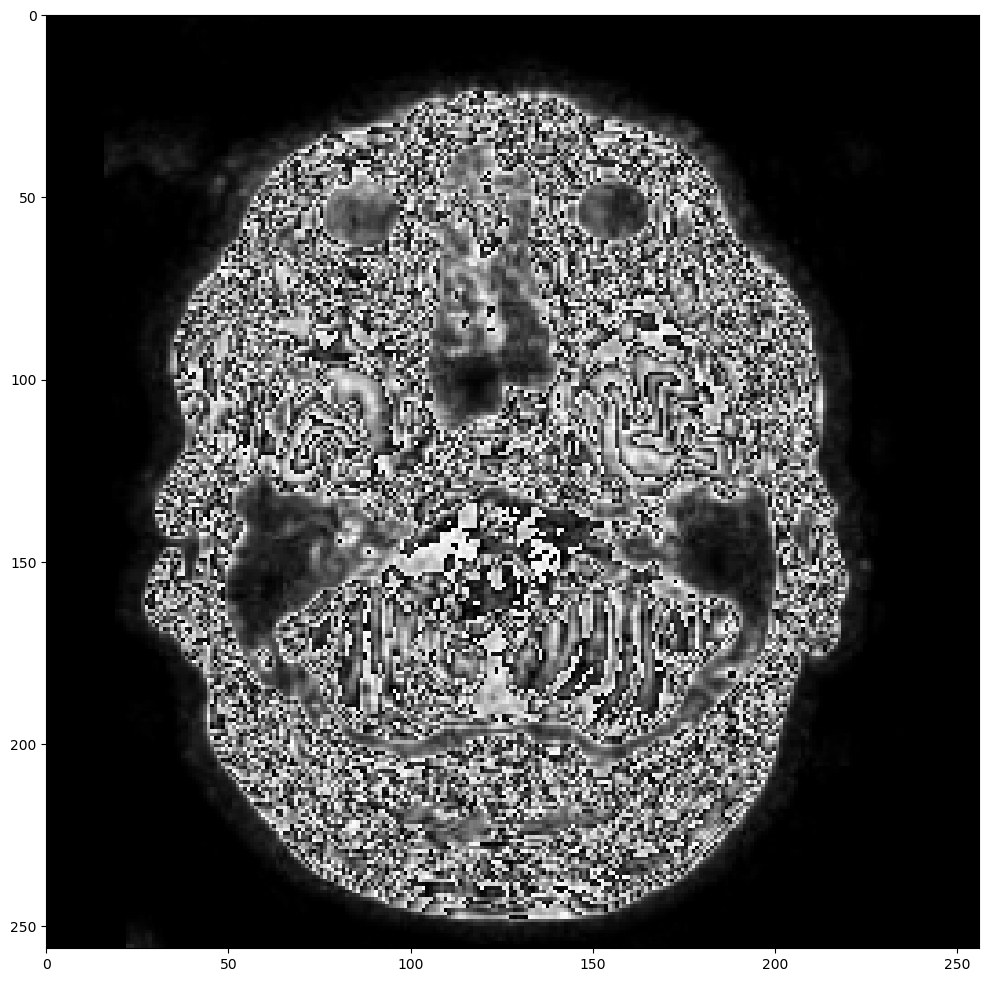

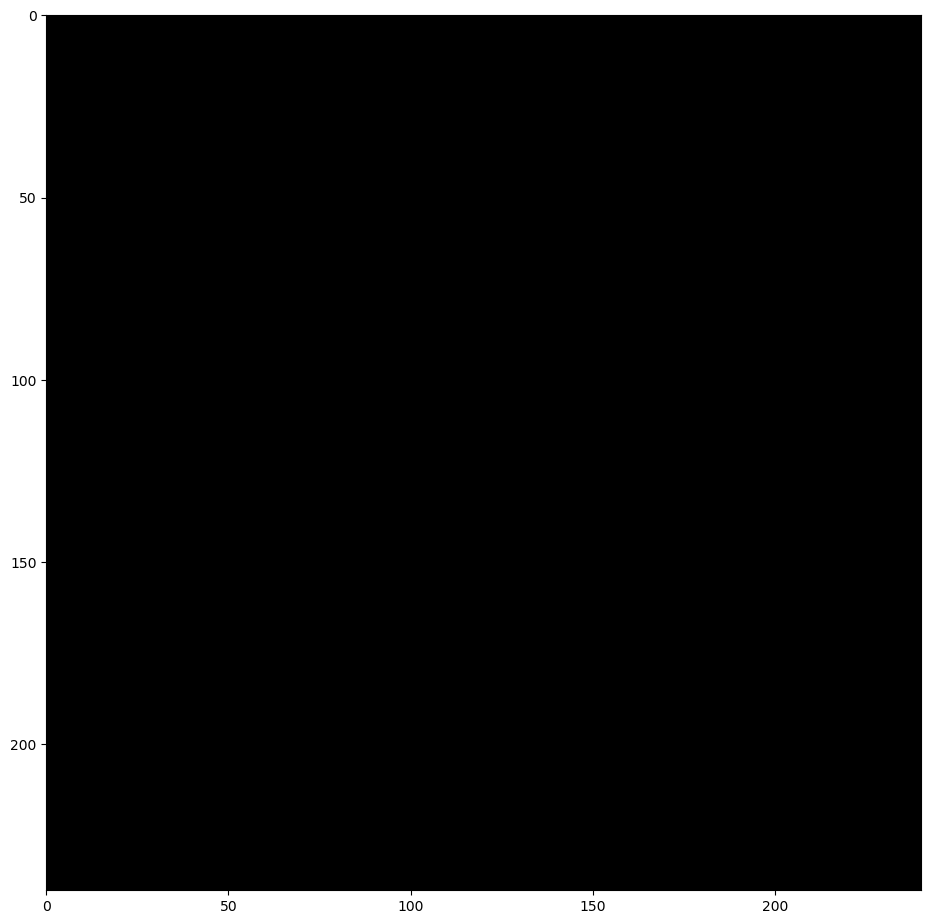

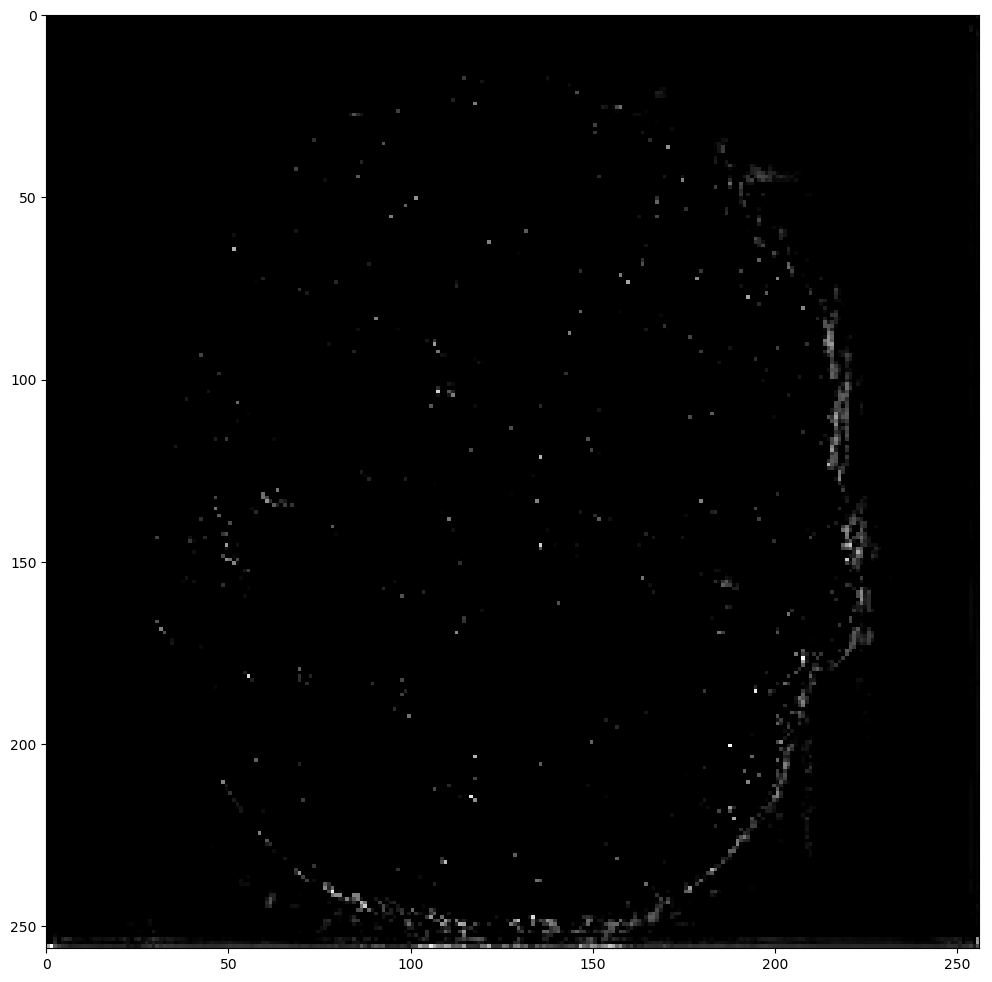

In [17]:
if __name__ == '__main__':
    for i,j in zip(Xchunks,ychunks):
        train_and_predict(i,j)